## Setup

Import TensorFlow and other necessary libraries:

In [8]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

## Load data using a Keras utility

Next, load these images off disk using the helpful tf.keras.utils.image_dataset_from_directory utility.
This will take you from a directory of images on disk to a tf.data.Dataset in just a couple lines of code.

In [9]:
BATCH_SIZE = 32
IMAGE_SIZE = (180, 180)

In [10]:
# Creation of the train, validation and test dataset
# The split for train, validation and test is 80 - 16 - 4

data_dir = "../data/raw"

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print(class_names)

Found 60992 files belonging to 51 classes.
Using 48794 files for training.
Found 60992 files belonging to 51 classes.
Using 12198 files for validation.
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Black-grass', 'Blueberry___healthy', 'Charlock', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Fat Hen', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Loose Silky-bent', 'Maize', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill',

As the original dataset doesn't contain a test set, you will create one.
To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [11]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5) # 4% of entire dataset
val_ds = val_ds.skip(val_batches // 5) # 16% of entire dataset

print('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))

Number of training batches: 1525
Number of validation batches: 306


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Transfer Learning approach

Create the base model from the pre-trained model MobileNetV2

In [13]:
# This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

base_model = MobileNetV2(input_shape=(180, 180, 3),
                         include_top=False,
                         weights='imagenet')

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# Freeze the base model
base_model.trainable = False

C:\Users\lume\AppData\Local\Temp\ipykernel_12072\3756985322.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(180, 180, 3),


(32, 6, 6, 1280)


In [14]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 90, 90,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 90, 90,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 90, 90,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 90, 90,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 90, 90,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 90, 90,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 90, 90,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 90, 90,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 90, 90,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 90, 90,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 90, 90,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 91, 91,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 45, 45,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 45, 45,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 45, 45,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 45, 45,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
# Add a classification head
global_average_layer = layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = layers.Dense(len(class_names), activation='softmax')

In [16]:
# Build the model
inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
layer = preprocess_input(inputs)
layer = base_model(layer, training=False)
layer = global_average_layer(layer)
layer = tf.keras.layers.Dropout(0.2)(layer)
outputs = prediction_layer(layer)

model = tf.keras.Model(inputs, outputs)

## Compile the model

Compile the model before training it. Since there are many classes and a softmax oputput, use the `categorical_crossentropy`.

In [11]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Train the model

After training for 10 epochs, you should see ~96% accuracy on the validation set.

In [12]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

306/306 ━━━━━━━━━━━━━━━━━━━━ 189s 496ms/step - accuracy: 0.0086 - loss: 5.0983


In [13]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10, verbose = 1, restore_best_weights = True)
lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 3, verbose = 1, cooldown = 5)

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks = [early_stopping, lr_plateau])

initial loss: 5.11
initial accuracy: 0.01
Epoch 1/10
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 969s 632ms/step - accuracy: 0.4206 - loss: 2.3798 - val_accuracy: 0.8338 - val_loss: 0.6524 - learning_rate: 1.0000e-04
Epoch 2/10
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 667s 438ms/step - accuracy: 0.8223 - loss: 0.6430 - val_accuracy: 0.8855 - val_loss: 0.4232 - learning_rate: 1.0000e-04
Epoch 3/10
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 665s 436ms/step - accuracy: 0.8736 - loss: 0.4416 - val_accuracy: 0.9066 - val_loss: 0.3359 - learning_rate: 1.0000e-04
Epoch 4/10
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 668s 438ms/step - accuracy: 0.8971 - loss: 0.3515 - val_accuracy: 0.9155 - val_loss: 0.2893 - learning_rate: 1.0000e-04
Epoch 5/10
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 650s 426ms/step - accuracy: 0.9106 - loss: 0.3015 - val_accuracy: 0.9238 - val_loss: 0.2603 - learning_rate: 1.0000e-04
Epoch 6/10
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 674s 442ms/step - accuracy: 0.9197 - loss: 0.2684 - val_accuracy: 0.9283 - val_loss: 0.2407 - learning_rat

## Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

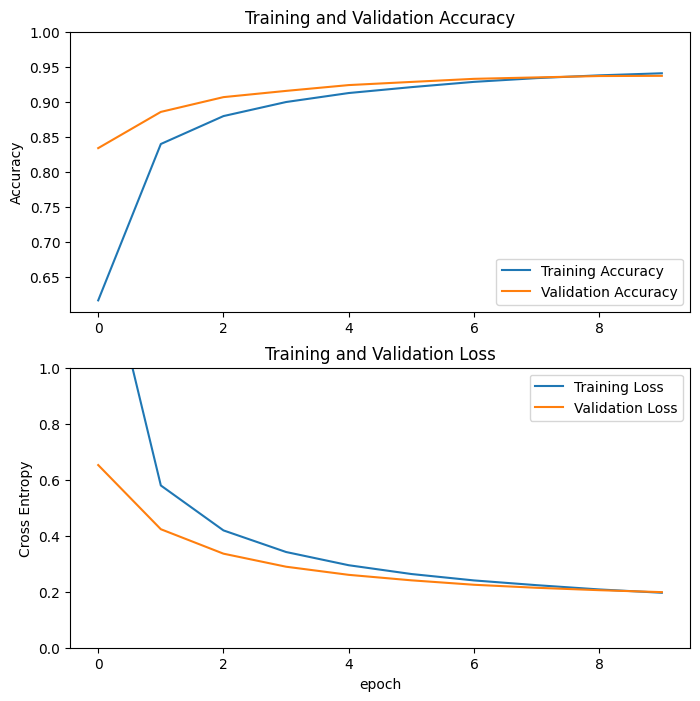

In [14]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

In [15]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


## Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [17]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=val_ds,
                         callbacks = [early_stopping, lr_plateau])

Epoch 11/20
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 1069s 689ms/step - accuracy: 0.8929 - loss: 0.3746 - val_accuracy: 0.9351 - val_loss: 0.1931 - learning_rate: 1.0000e-04
Epoch 12/20
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 1017s 667ms/step - accuracy: 0.9830 - loss: 0.0540 - val_accuracy: 0.9753 - val_loss: 0.0768 - learning_rate: 1.0000e-04
Epoch 13/20
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 1014s 665ms/step - accuracy: 0.9925 - loss: 0.0241 - val_accuracy: 0.9711 - val_loss: 0.0968 - learning_rate: 1.0000e-04
Epoch 14/20
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 1002s 657ms/step - accuracy: 0.9928 - loss: 0.0235 - val_accuracy: 0.9748 - val_loss: 0.0913 - learning_rate: 1.0000e-04
Epoch 15/20
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.9945 - loss: 0.0163
Epoch 15: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 1005s 659ms/step - accuracy: 0.9945 - loss: 0.0163 - val_accuracy: 0.9693 - val_loss: 0.1111 - learning_rate: 1.0000e-04
Epoch 16/20
1525/1525 ━

### Saving the model

In [ ]:
# Saving the model
model.save("../models/TL_180px_32b_20e_model_LuMe.keras")

In [17]:
# Loading the model - optional
# model = tf.keras.models.load_model("../models/TL_180px_32b_20e_model_LuMe.keras")

In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 6, 6, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 51)             │        65,331 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,176,859 (23.56 MB)

 Trainable params: 1,926,771 (7.35 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 3,853,544 (14.70 MB)

## Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [19]:
import numpy as np

# Creating the true and predicted classes for test_ds
test_classes = np.array([])
predicted_classes = np.array([])

for x, y in test_ds:
  predicted_classes = np.concatenate([predicted_classes, np.argmax(model(x, training=False), axis = -1)]).astype(int)
  test_classes = np.concatenate([test_classes, y.numpy()]).astype(int)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

# Print the classification report, for this we "translate" the labels
c_true_class = np.array(class_names)[test_classes]
c_predicted_class = np.array(class_names)[predicted_classes]

print("LeNet")
print(classification_report(c_true_class, c_predicted_class))

LeNet
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      1.00      1.00        22
                            Apple___Black_rot       1.00      1.00      1.00        33
                     Apple___Cedar_apple_rust       1.00      1.00      1.00         9
                              Apple___healthy       1.00      1.00      1.00        72
                    Background_without_leaves       1.00      1.00      1.00        50
                                  Black-grass       1.00      0.50      0.67        14
                          Blueberry___healthy       1.00      1.00      1.00        61
                                     Charlock       1.00      1.00      1.00         9
                      Cherry___Powdery_mildew       1.00      1.00      1.00        40
                             Cherry___healthy       1.00      1.00      1.00        30
                                    

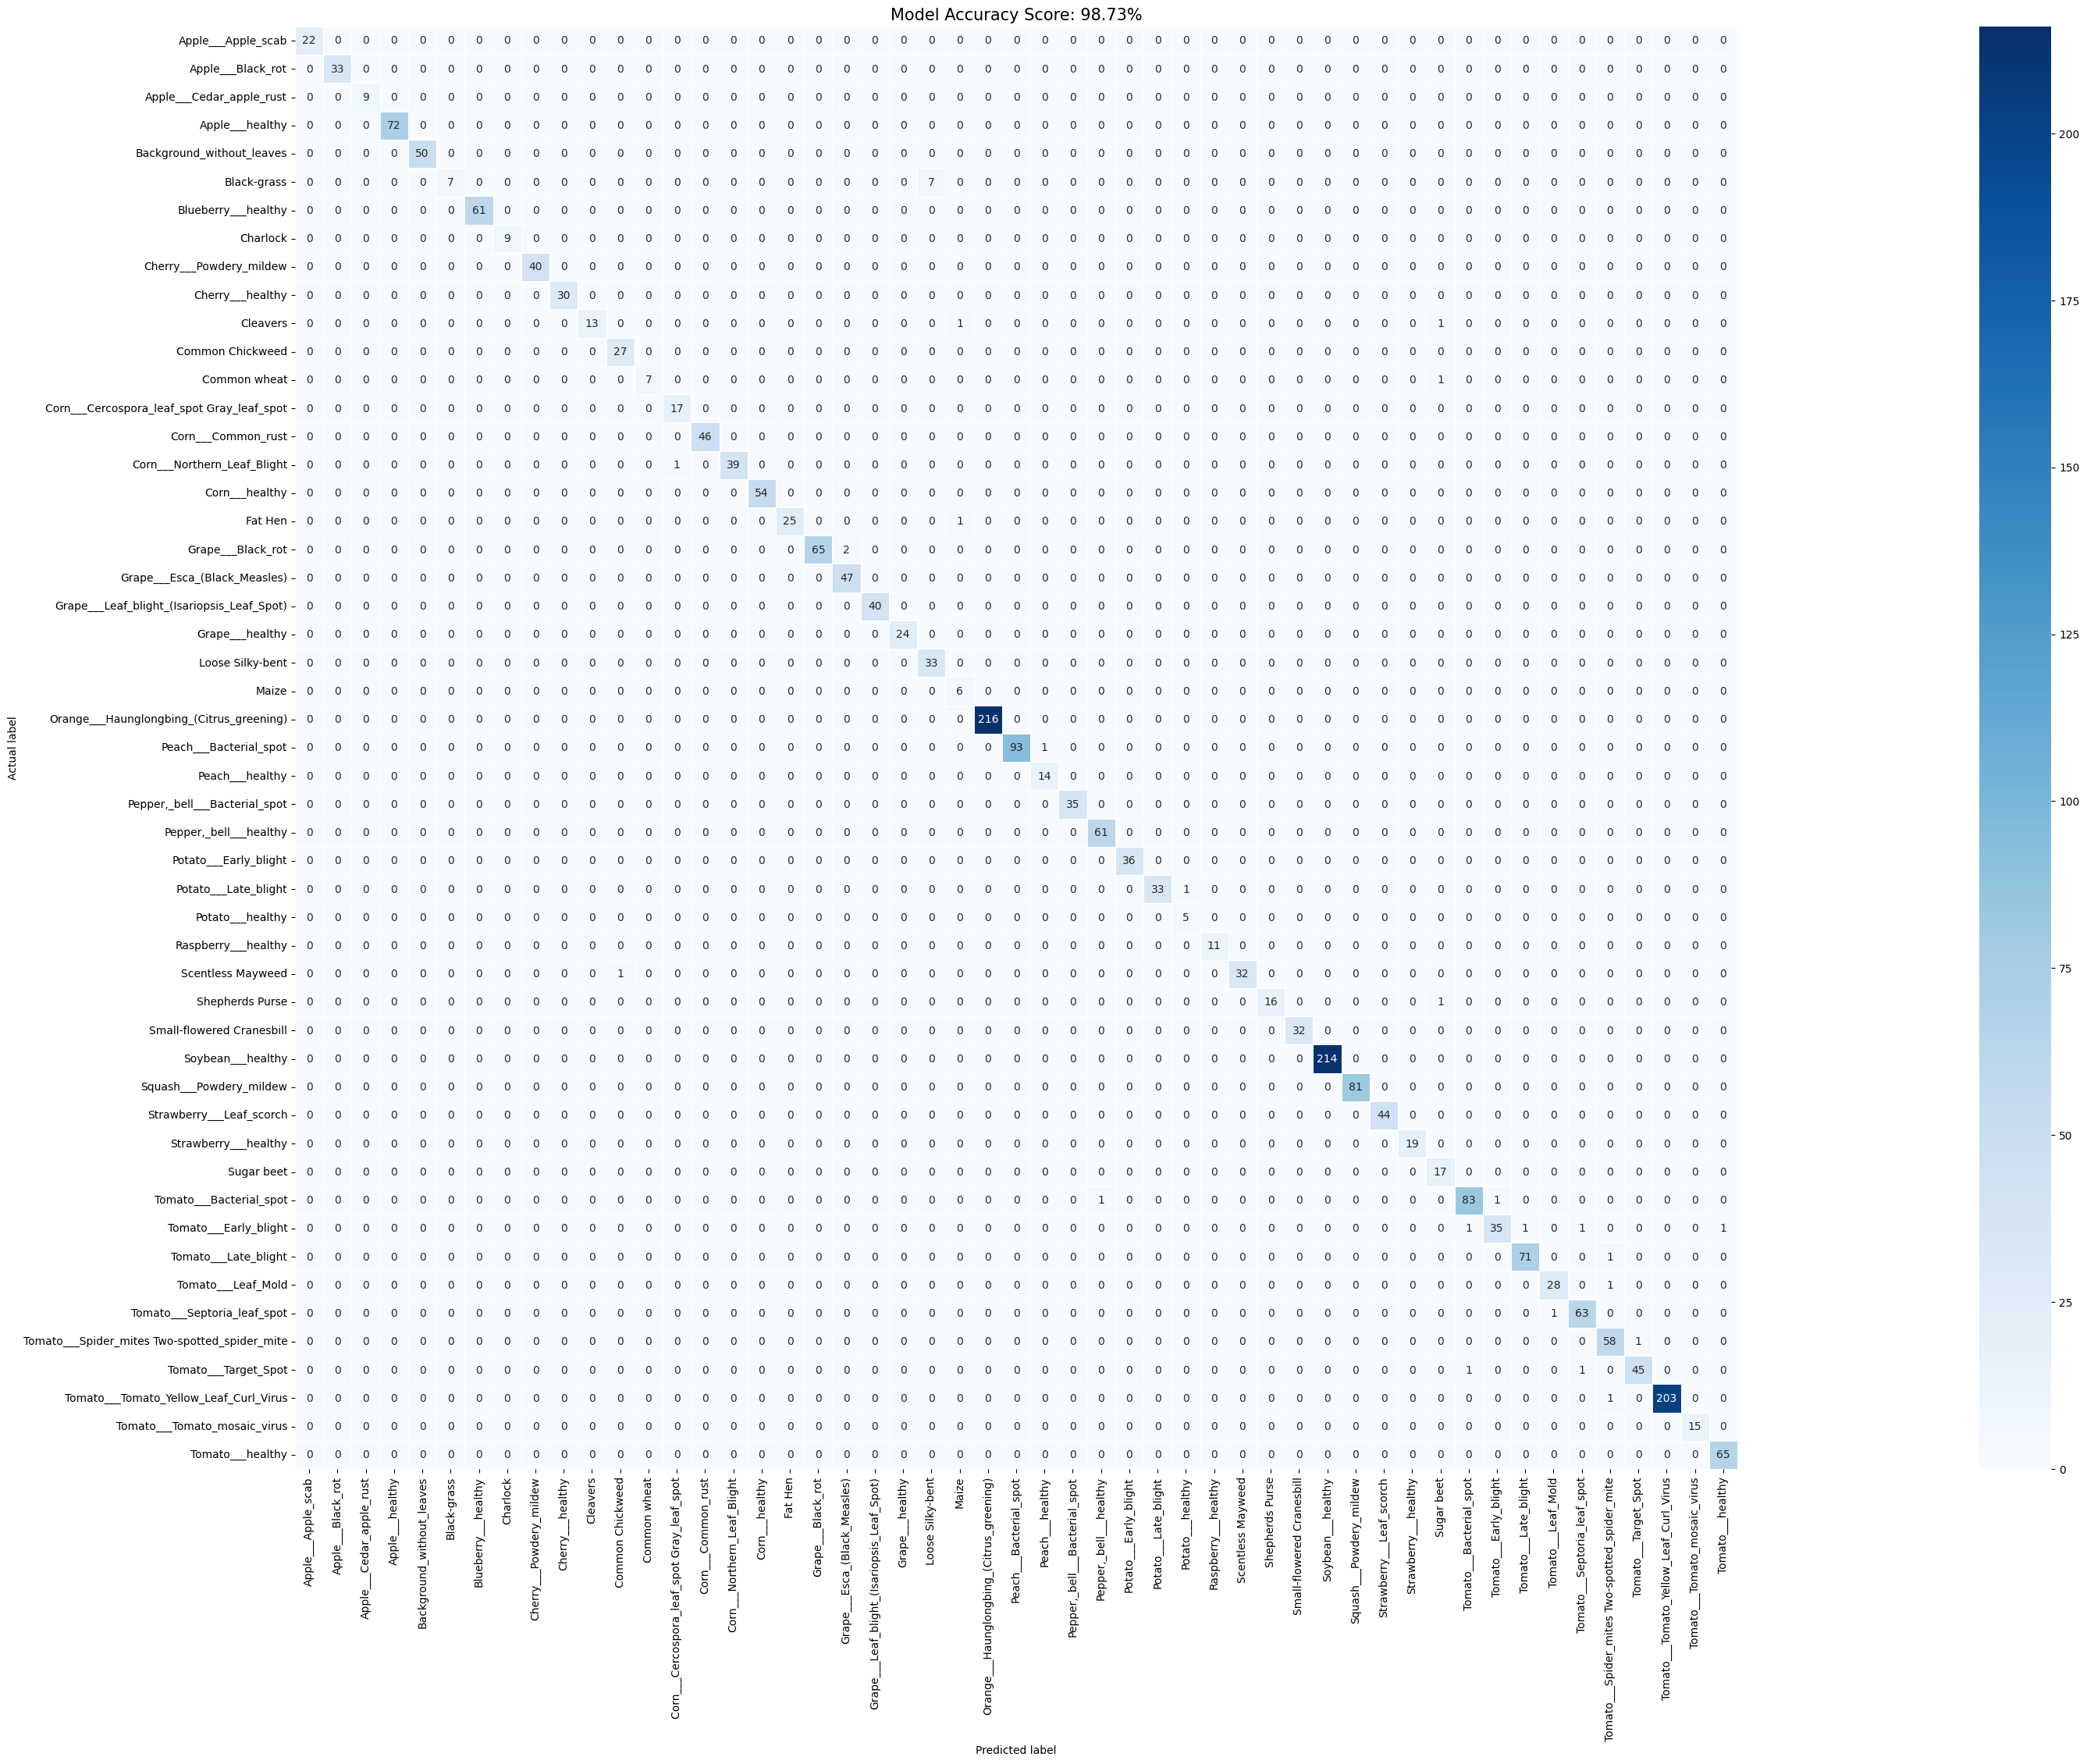

In [21]:
import seaborn as sns

# generate confusion matrix
loss_acc_tuple = model.evaluate(test_ds, verbose=0) #loss_acc_tuple = (loss_acc_tuple[0], loss_acc_tuple[1]) = loss, acc
cm = confusion_matrix(test_classes, predicted_classes)

plt.figure(figsize=(80,24))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues', yticklabels=class_names, xticklabels=class_names)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Model Accuracy Score: {loss_acc_tuple[1]:.2%}'
plt.title(all_sample_title, size = 15)
plt.show()
plt.close()

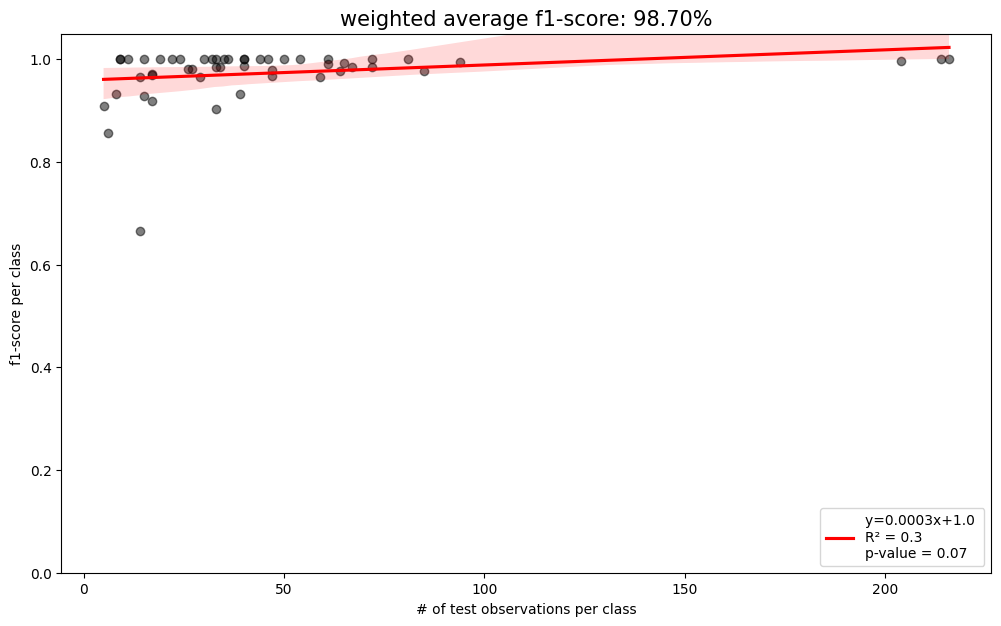

In [22]:
# plot regression model with 99% confidence interval

from sklearn.metrics import precision_recall_fscore_support as score
from scipy.stats import linregress

_,_,fscore,support = score(test_classes,predicted_classes)
_,_,fscore_wavg,_ = score(test_classes,predicted_classes,average='weighted')
slope, intercept, r_value, p_value, _ = linregress(support,fscore)

plt.figure(figsize=(12,7))
ax = sns.regplot(x = support, y = fscore,
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red", 'label':"y={0:.4f}x+{1:.1f} \nR² = {2:.1f} \np-value = {3:.2f}".format(slope,intercept,r_value, p_value)},
            ci = 99)
plt.ylim((0,1.05))
plt.ylabel('f1-score per class')
plt.xlabel('# of test observations per class')
all_sample_title = f'weighted average f1-score: {fscore_wavg:.2%}'
plt.title(all_sample_title, size = 15)
ax.legend(loc="lower right")
#ax.legend()
plt.show()
plt.close();

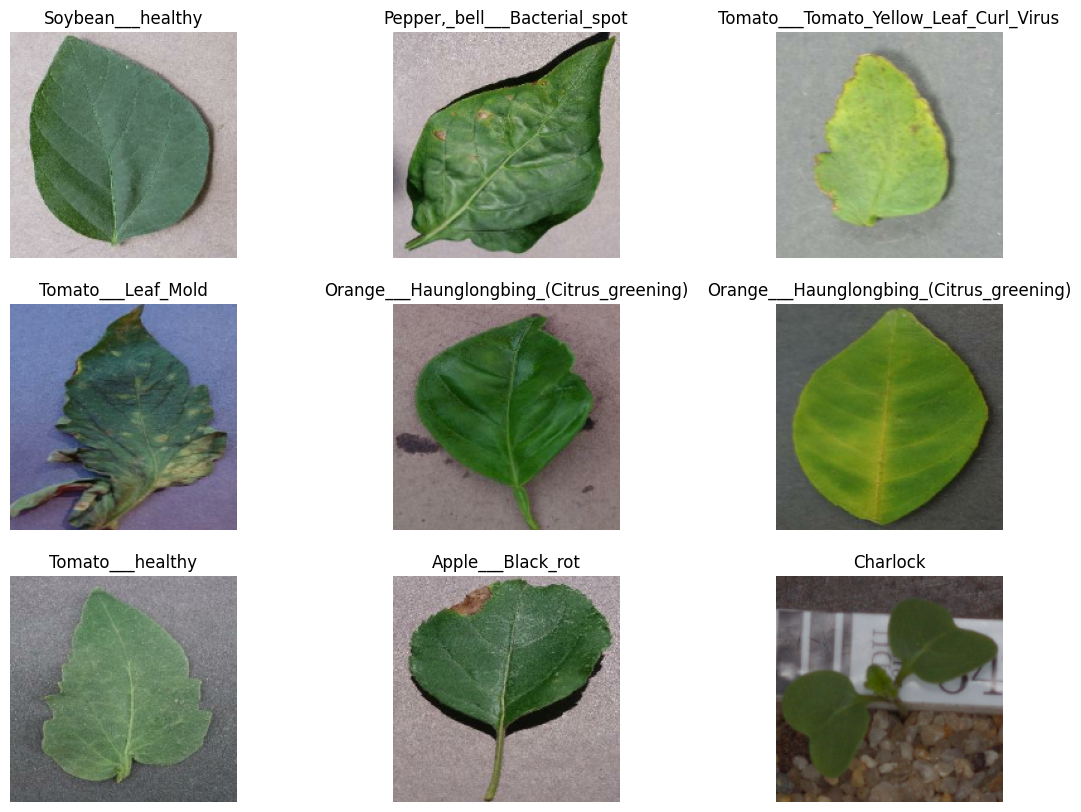

In [23]:
# Plotting some of the images - just for info

plt.figure(figsize=(14, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")